# Table of contents
### code cells that didn't work as expected are turned into Raw NBConvert

1.  Importing packages
2.  Setting up functions
3.  Downloading data
4.  Looking into data
5.  Modifying dataframe
6.  Unit root test
7.  VECM VAR lag order determination
8.  VECM conintegration test
9.  VECM estimation
10.  Model performance evaluation
11. Impluse response function
12. Granger causality

# Importing packages

In [594]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import cvxpy as cp
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron
from statsmodels.tsa.vector_ar import vecm

# Setting up functions

In [595]:
def test_stationarity(data):
    rolling_mean = data.rolling(window=7).mean()
    rolling_std = data.rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(data, label='Original')
    ax.plot(rolling_mean, label='Rolling Mean')
    ax.plot(rolling_std, label='Rolling Std')
    
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.title('Rolling Mean and Standard Deviation - {}'.format(data.name))
    plt.tight_layout()
    plt.show()
    
    result = adfuller(data)
    print('Augumented Dickey-Fuller Test')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
def causality_vs_all(data, model):
    columns = data.columns.tolist()

    for i in range(len(columns)):
        vs = deepcopy(columns)
        tv = vs.pop(i)
        result = model.test_causality(tv, vs, kind='f')
        print(result.summary())
        
def causality_vs_each(data, model):
    columns = data.columns.tolist()

    for i in range(len(columns)):
        vs = deepcopy(columns)
        tv = vs.pop(i)
        for v in vs:
            result = model.test_granger_causality(tv, v, signif = 0.05)
            print(result.summary())
            print("\n")
        

# Downloading data
##   try monthly data
##   20 year horizon
###     - semiconductor industry
###     - hardware industry
###     - gold price
###     - US CPI
###     - volatility index
###     - 10Y USTB
###     - dollar index

In [596]:
sc = ["ADI", "AMAT", "INTC", "MCHP", "MU", "NVDA", "QCOM", "SWKS", "TXN"]
hd = ["AAPL", "HPQ", "NTAP", "WDC"]
macro = ["GC=F", "^VIX", "^TNX", "DX-Y.NYB", "^GSPC"]

In [597]:
start_date = "2000-09-01"
end_date = "2023-5-31"

# Define the ticker symbol for US CPI data from FRED
cpi_ticker = "CPIAUCSL"  # CPIAUCSL represents the Consumer Price Index for All Urban Consumers

# Use pandas_datareader to fetch the data from FRED
cpi_data = pdr.get_data_fred(cpi_ticker, start_date, end_date)

# Save the CPI data to a CSV file
#cpi_data.to_csv("US_CPI_data.csv")
cpi_data

,CPIAUCSL
DATE,
2000-09-01,173.600
2000-10-01,173.900
2000-11-01,174.200
2000-12-01,174.600
2001-01-01,175.600
...,...
2023-01-01,300.536
2023-02-01,301.648
2023-03-01,301.808


In [730]:
start_date = "2000-09-01"
end_date = "2023-5-31"
ticker = sc + hd + macro
df = pd.DataFrame()
for i in ticker:
    # Use yfinance to fetch the gold price data
    data = yf.download(i, start=start_date, end=end_date, interval = "1mo")
    df = pd.concat([df, data["Adj Close"]], axis=1)
    
df.columns = ticker
df = pd.concat([df, cpi_data],axis=1)
df.head(50)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC,CPIAUCSL
2000-09-01,52.679089,21.914021,24.025658,6.357817,45.282055,3.129760,23.153259,29.379440,30.937292,0.390294,13.658391,98.183113,4.716438,273.600006,20.570000,5.778,113.250000,1436.510010,173.600
2000-10-01,41.379341,19.627945,26.012720,6.081390,34.207642,2.375392,21.157816,34.392796,31.954966,0.296510,13.115534,91.727486,4.816789,NaN,23.629999,5.757,116.650002,1429.400024,173.900
2000-11-01,31.591536,14.940331,22.002436,4.494941,31.008366,1.548156,26.077890,26.360632,24.313593,0.250092,8.919976,38.059208,2.609093,270.100006,29.650000,5.439,115.239998,1314.949951,174.200
2000-12-01,32.586243,14.109025,17.385403,4.218513,34.945934,1.252501,26.707499,31.913076,30.870539,0.225462,8.902346,49.476963,1.956820,272.000000,26.850000,5.110,109.559998,1320.280029,174.600
2001-01-01,39.851482,18.588818,21.397419,5.780923,45.055649,1.973421,27.316786,25.875458,28.540983,0.327772,10.420069,41.335186,4.238773,265.600006,22.020000,5.179,110.519997,1366.010010,175.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,169.058472,110.703476,27.706257,76.516518,59.965321,195.300507,130.563614,107.687889,171.818451,143.677002,28.367645,64.318542,43.950001,NaN,19.400000,3.529,102.099998,4076.600098,300.536
2023-02-01,180.889709,115.330597,24.441507,79.878029,57.499084,232.077438,121.075920,109.553543,167.418320,146.783752,28.737574,63.197262,38.480000,1828.900024,20.700001,3.916,104.870003,3970.149902,301.648
2023-03-01,195.351273,122.249100,32.420124,82.939751,60.005100,277.671173,125.045464,116.491867,181.635941,164.450150,28.572079,62.511925,37.669998,1969.000000,18.700001,3.494,102.510002,4109.310059,301.808
2023-04-01,178.175568,112.495445,30.822439,72.257965,64.002792,277.438416,115.178917,104.564232,163.268280,169.217117,29.191256,61.572048,34.439999,1990.099976,15.780000,3.452,101.669998,4169.479980,302.918


In [731]:
for column in df.columns:
    if df[column].isna().any():
        print(column)
        print(df[column].isna().sum())



GC=F
40


In [732]:
df = df.interpolate()


# Looking into data & forming dataframe

<Axes: >

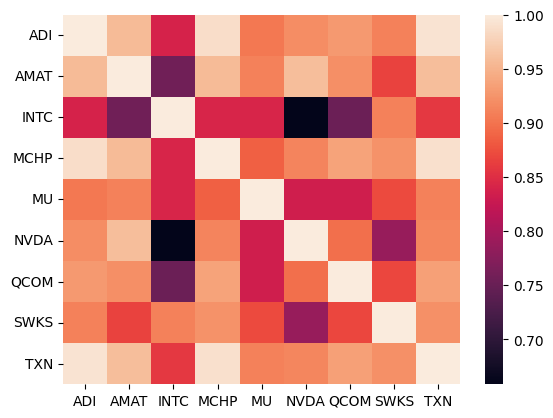

In [733]:
sns.heatmap(df[sc].corr())

<Axes: >

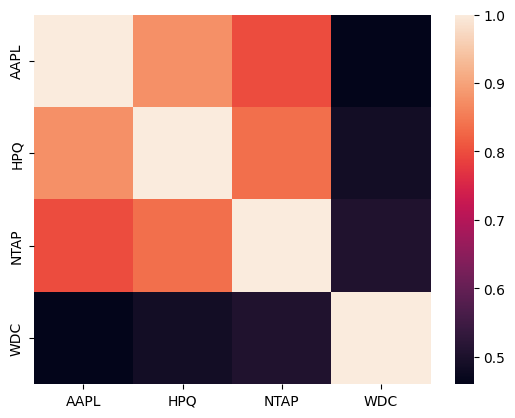

In [734]:
sns.heatmap(df[hd].corr())

<Axes: >

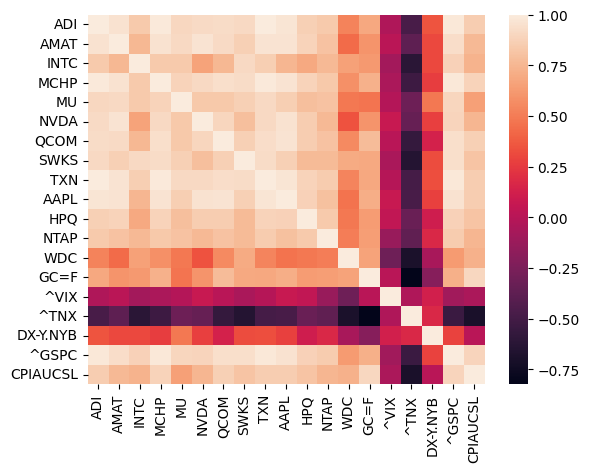

In [735]:
sns.heatmap(df.corr())

In [736]:
df[sc] = np.log(df[sc]z)

SyntaxError: invalid syntax (1509932244.py, line 1)

In [737]:
df[hd] = np.log(df[hd])

In [738]:
df["^GSPC"] = np.log(df["^GSPC"])

In [739]:
df

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC,CPIAUCSL
2000-09-01,52.679089,21.914021,24.025658,6.357817,45.282055,3.129760,23.153259,29.379440,30.937292,-0.940854,2.614354,4.586834,1.551054,273.600006,20.570000,5.778,113.250000,7.269972,173.600
2000-10-01,41.379341,19.627945,26.012720,6.081390,34.207642,2.375392,21.157816,34.392796,31.954966,-1.215674,2.573797,4.518822,1.572107,271.850006,23.629999,5.757,116.650002,7.265010,173.900
2000-11-01,31.591536,14.940331,22.002436,4.494941,31.008366,1.548156,26.077890,26.360632,24.313593,-1.385927,2.188293,3.639143,0.959003,270.100006,29.650000,5.439,115.239998,7.181554,174.200
2000-12-01,32.586243,14.109025,17.385403,4.218513,34.945934,1.252501,26.707499,31.913076,30.870539,-1.489606,2.186315,3.901507,0.671321,272.000000,26.850000,5.110,109.559998,7.185599,174.600
2001-01-01,39.851482,18.588818,21.397419,5.780923,45.055649,1.973421,27.316786,25.875458,28.540983,-1.115437,2.343734,3.721714,1.444274,265.600006,22.020000,5.179,110.519997,7.219649,175.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,169.058472,110.703476,27.706257,76.516518,59.965321,195.300507,130.563614,107.687889,171.818451,4.967568,3.345249,4.163848,3.783053,1824.299988,19.400000,3.529,102.099998,8.313019,300.536
2023-02-01,180.889709,115.330597,24.441507,79.878029,57.499084,232.077438,121.075920,109.553543,167.418320,4.988960,3.358205,4.146261,3.650139,1828.900024,20.700001,3.916,104.870003,8.286559,301.648
2023-03-01,195.351273,122.249100,32.420124,82.939751,60.005100,277.671173,125.045464,116.491867,181.635941,5.102607,3.352430,4.135357,3.628864,1969.000000,18.700001,3.494,102.510002,8.321010,301.808
2023-04-01,178.175568,112.495445,30.822439,72.257965,64.002792,277.438416,115.178917,104.564232,163.268280,5.131183,3.373869,4.120208,3.539219,1990.099976,15.780000,3.452,101.669998,8.335547,302.918


ADI


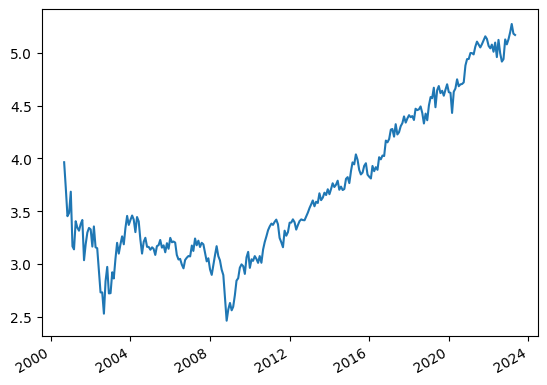

AMAT


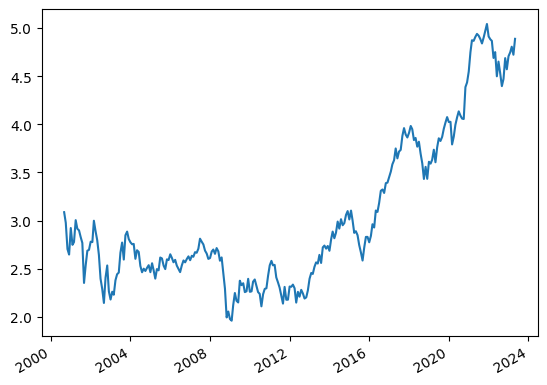

INTC


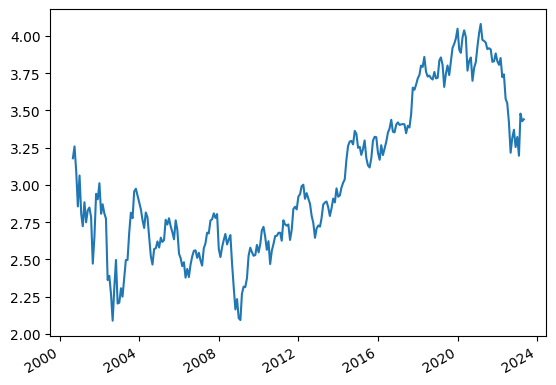

MCHP


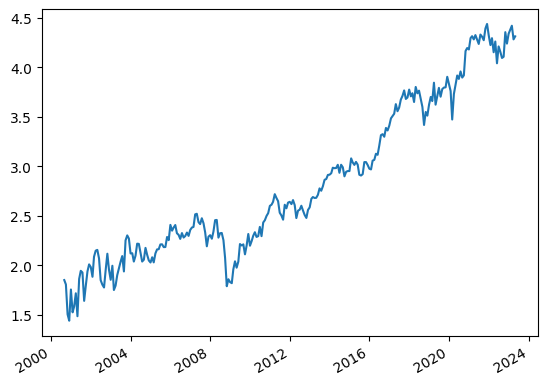

MU


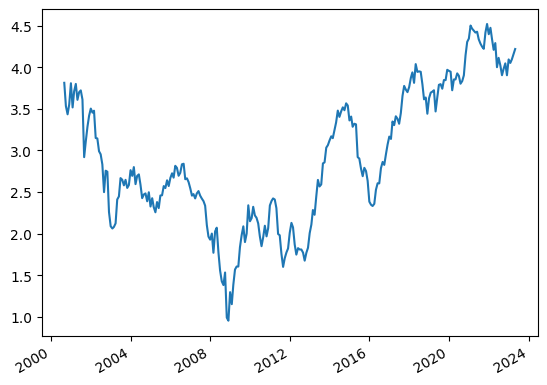

NVDA


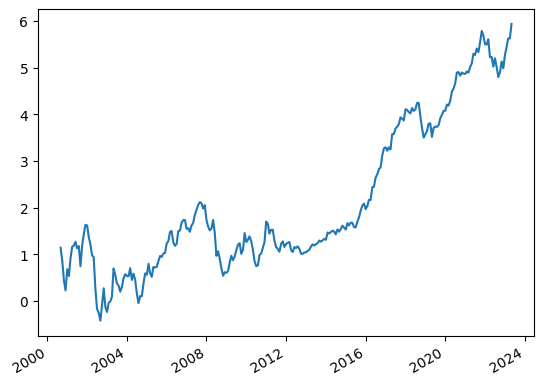

QCOM


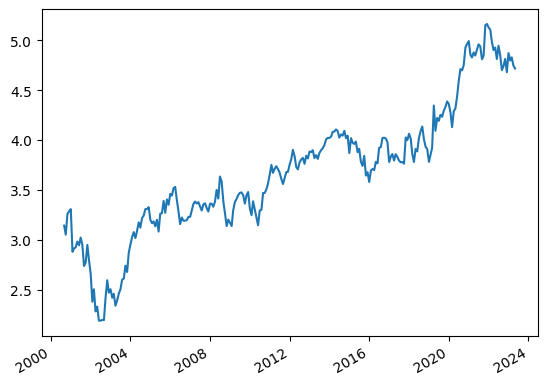

SWKS


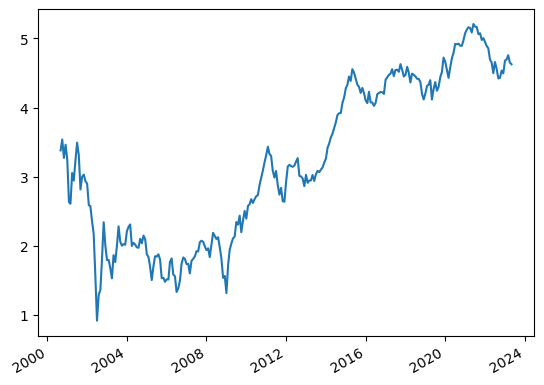

TXN


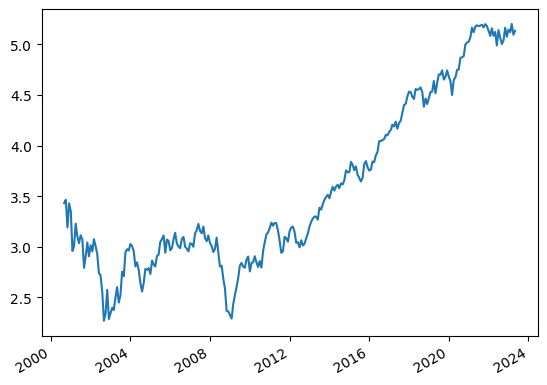

AAPL


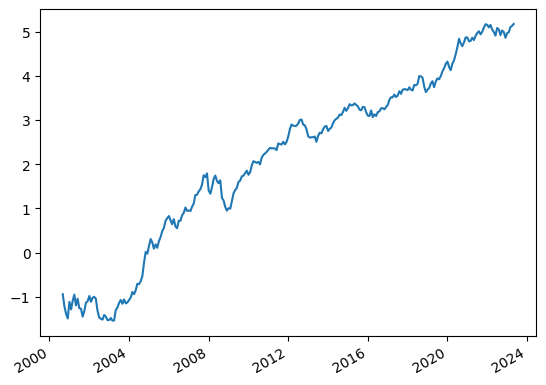

HPQ


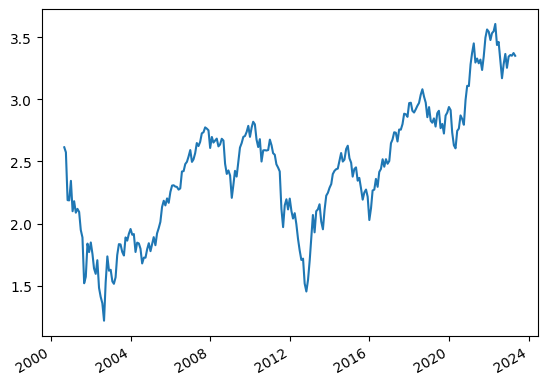

NTAP


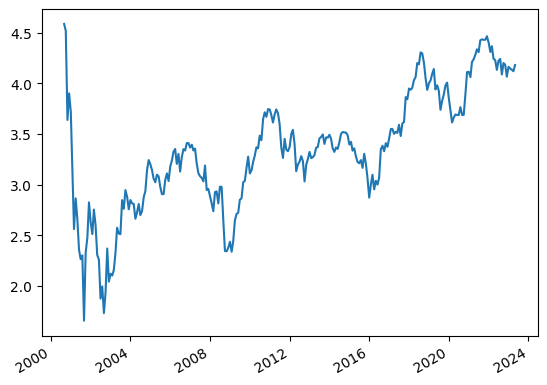

WDC


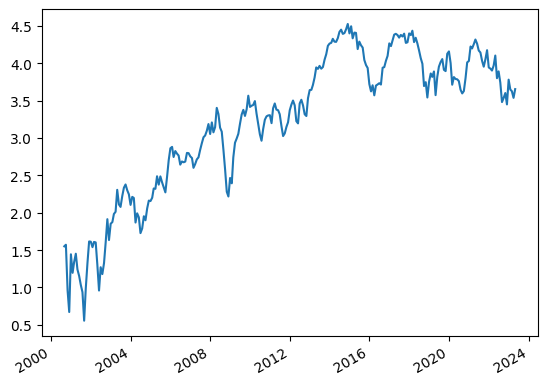

GC=F


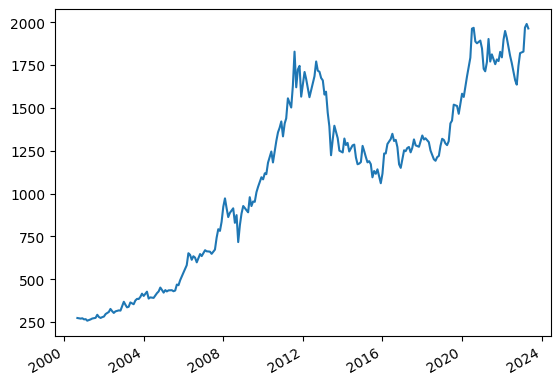

^VIX


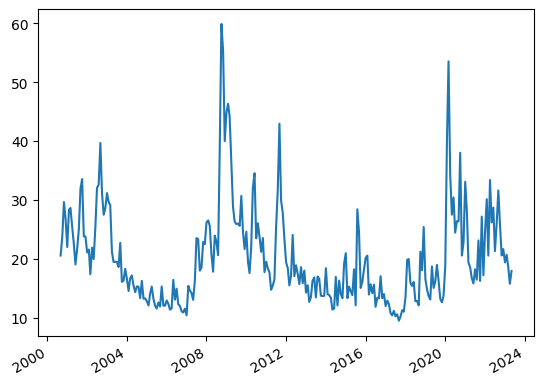

^TNX


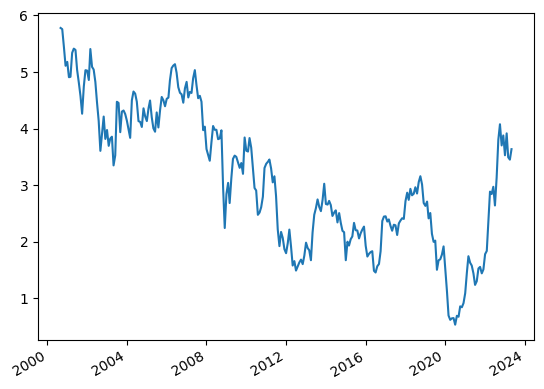

DX-Y.NYB


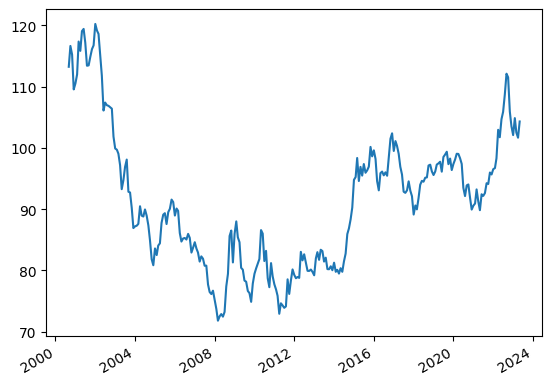

^GSPC


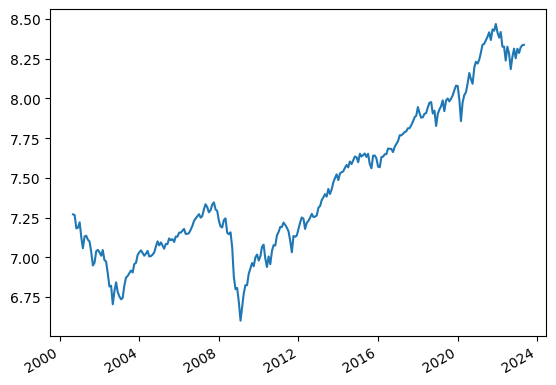

CPIAUCSL


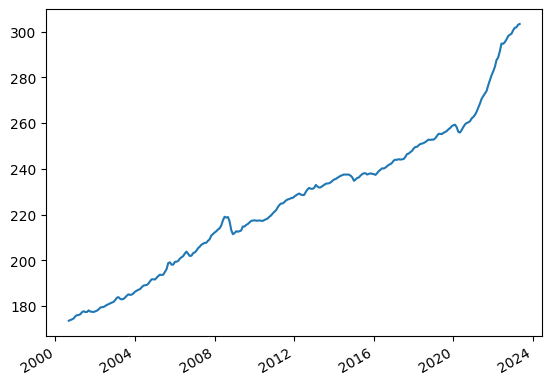

In [608]:
for column in df.columns:
    #plt.subplot(221)
    print(column)
    df[column].plot()
    plt.show()

ADI


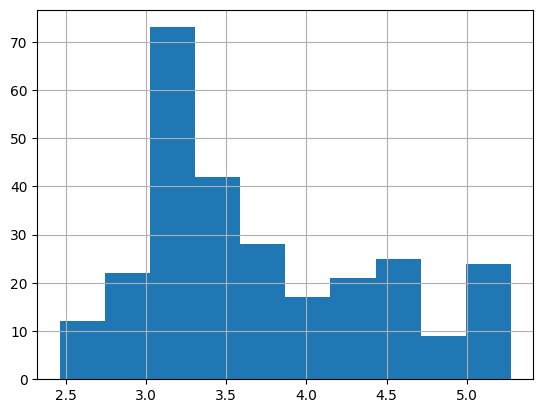

AMAT


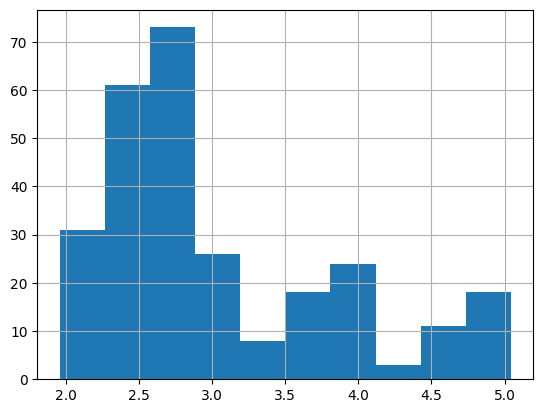

INTC


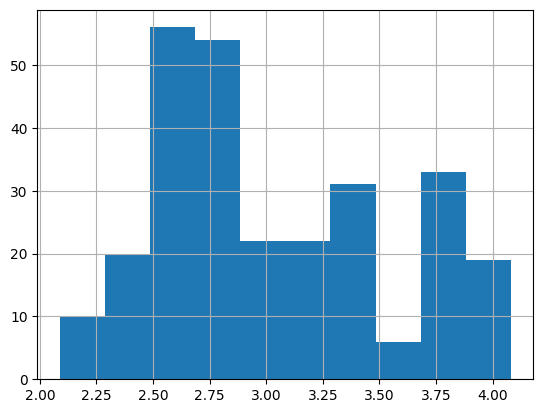

MCHP


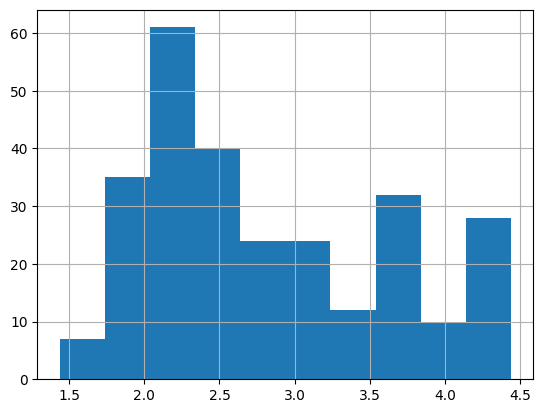

MU


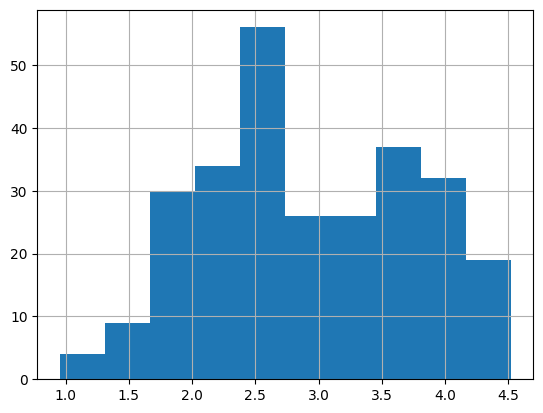

NVDA


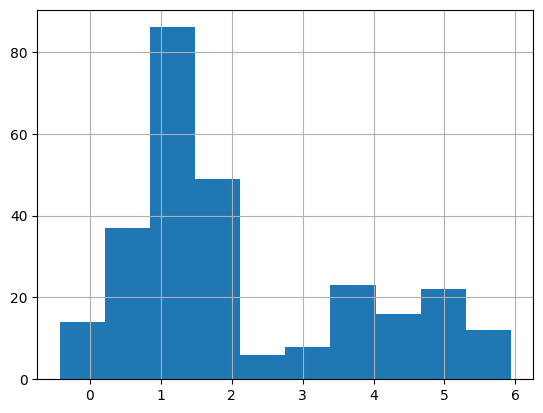

QCOM


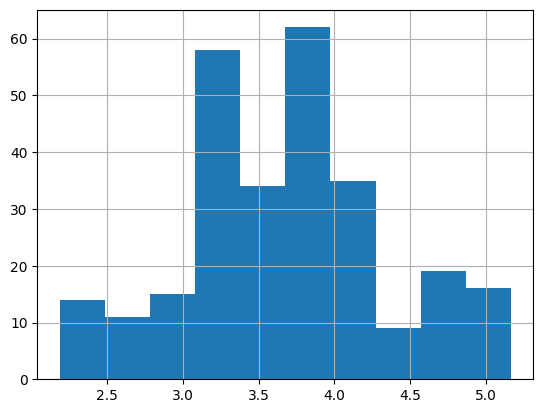

SWKS


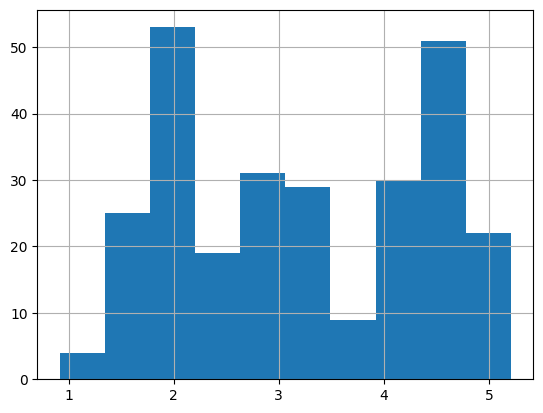

TXN


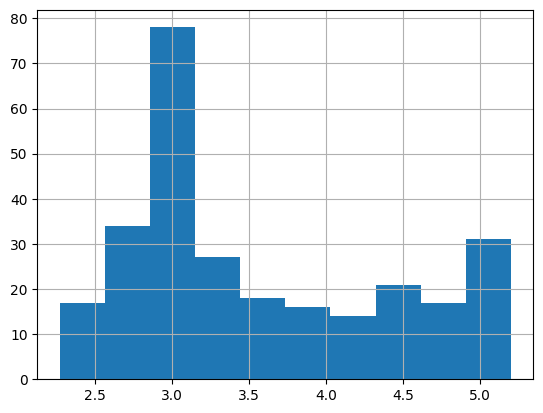

AAPL


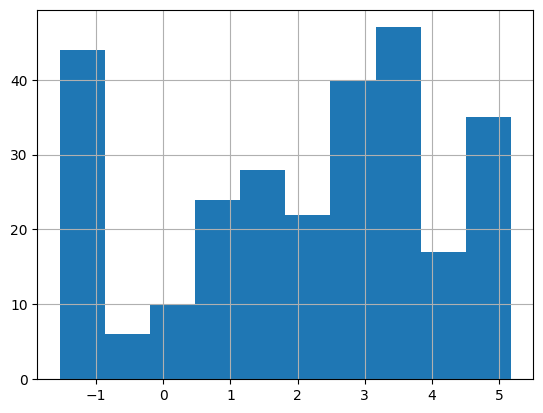

HPQ


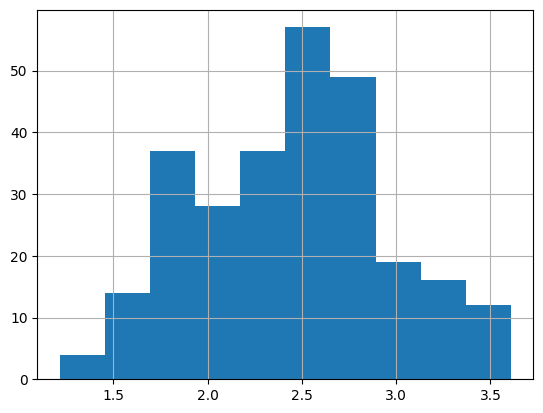

NTAP


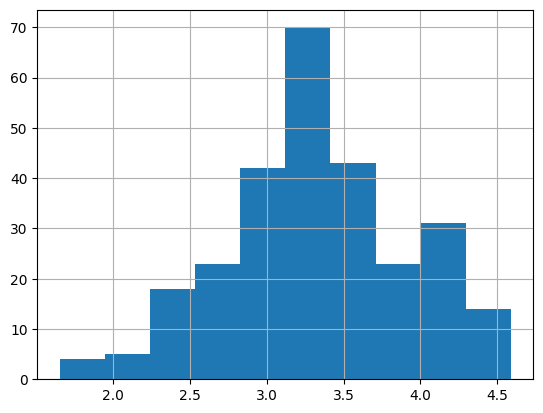

WDC


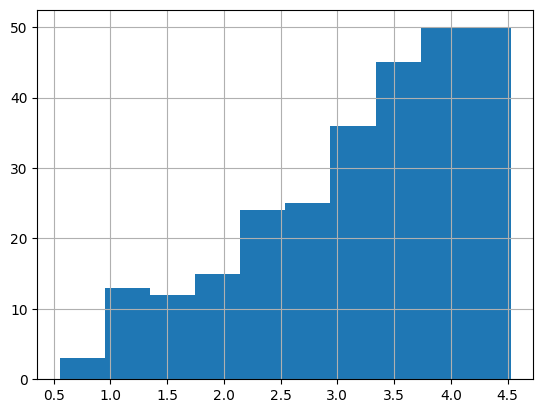

GC=F


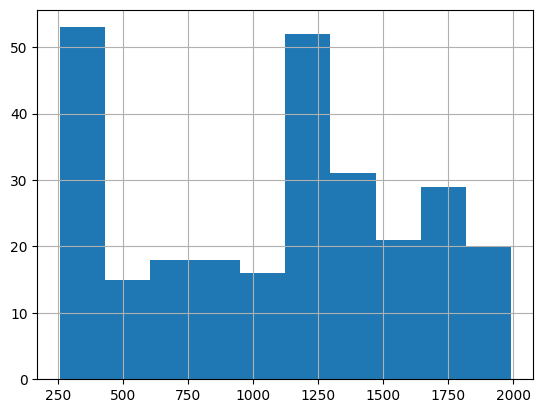

^VIX


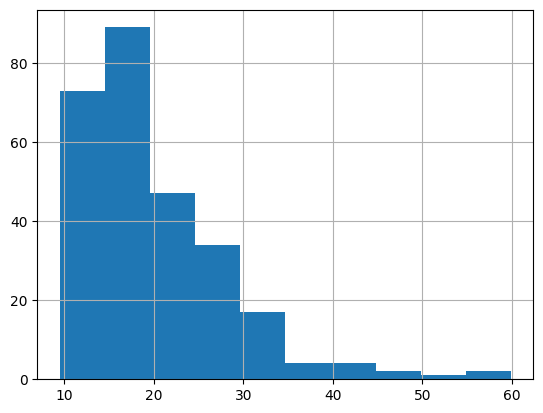

^TNX


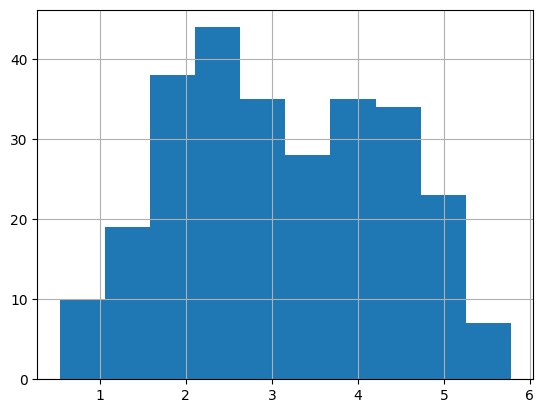

DX-Y.NYB


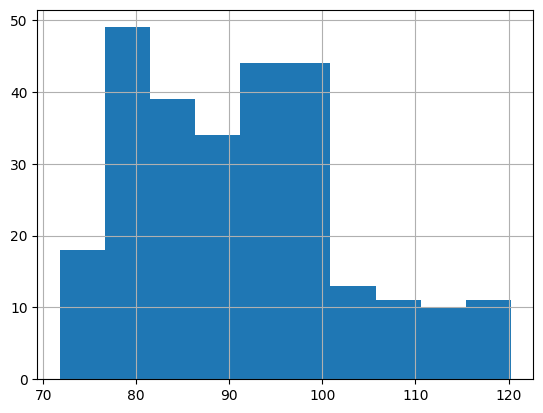

^GSPC


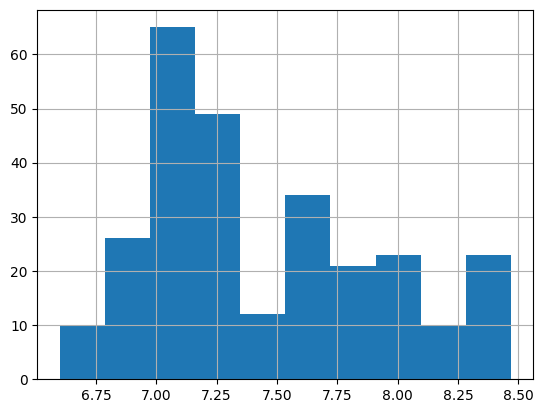

CPIAUCSL


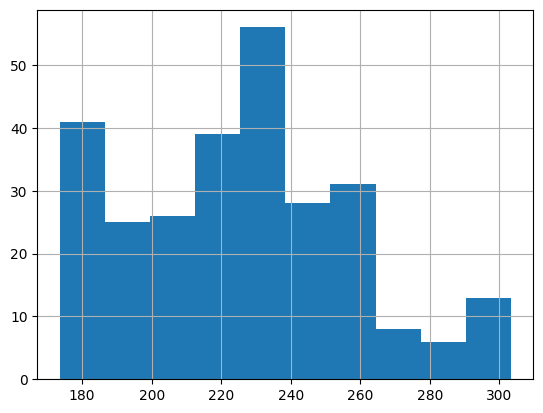

In [609]:
for column in df.columns:
    #plt.subplot(221)
    print(column)
    df[column].hist()
    plt.show()

In [610]:
df["semicon"] = df[sc].mean(axis=1)
df["hardware"] = df[hd].mean(axis=1)

In [611]:
df

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,...,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC,CPIAUCSL,semicon,hardware
2000-09-01,3.964218,3.087126,3.179122,1.849685,3.812911,1.140956,3.142136,3.380295,3.431962,-0.940854,...,4.586834,1.551054,273.600006,20.570000,5.778,113.250000,7.269972,173.600,2.998712,1.952847
2000-10-01,3.722782,2.976954,3.258586,1.805233,3.532449,0.865163,3.052009,3.537847,3.464328,-1.215674,...,4.518822,1.572107,271.850006,23.629999,5.757,116.650002,7.265010,173.900,2.912817,1.862263
2000-11-01,3.452889,2.704064,3.091154,1.502953,3.434257,0.437065,3.261088,3.271872,3.191036,-1.385926,...,3.639143,0.959003,270.100006,29.650000,5.439,115.239998,7.181554,174.200,2.705153,1.350128
2000-12-01,3.483890,2.646814,2.855631,1.439483,3.553802,0.225143,3.284944,3.463016,3.429802,-1.489606,...,3.901507,0.671321,272.000000,26.850000,5.110,109.559998,7.185599,174.600,2.709169,1.317384
2001-01-01,3.685160,2.922560,3.063270,1.754564,3.807898,0.679770,3.307501,3.253295,3.351341,-1.115437,...,3.721714,1.444274,265.600006,22.020000,5.179,110.519997,7.219649,175.600,2.869484,1.598571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,5.130245,4.706855,3.321658,4.337507,4.093766,5.274539,4.871861,4.679237,5.146438,4.967568,...,4.163848,3.783053,1824.299988,19.400000,3.529,102.099998,8.313019,300.536,4.618012,4.064929
2023-02-01,5.197887,4.747803,3.196283,4.380501,4.051769,5.447071,4.796418,4.696413,5.120496,4.988960,...,4.146261,3.650139,1828.900024,20.700001,3.916,104.870003,8.286559,301.648,4.626071,4.035891
2023-03-01,5.274799,4.806061,3.478779,4.418114,4.094430,5.626438,4.828677,4.757821,5.202004,5.102607,...,4.135357,3.628864,1969.000000,18.700001,3.494,102.510002,8.321010,301.808,4.720792,4.054815
2023-04-01,5.182769,4.722913,3.428243,4.280243,4.158927,5.625599,4.746487,4.649802,5.095395,5.131183,...,4.120208,3.539219,1990.099976,15.780000,3.452,101.669998,8.335547,302.918,4.654486,4.041120


In [698]:
read = df[["CPIAUCSL", "DX-Y.NYB", "^TNX", "GC=F", "^VIX", "semicon", "hardware", "^GSPC"]]
read = df[["hardware", "semicon", "^GSPC", "^VIX", "GC=F", "^TNX", "DX-Y.NYB", "CPIAUCSL"]]
read

,hardware,semicon,^GSPC,^VIX,GC=F,^TNX,DX-Y.NYB,CPIAUCSL
2000-09-01,1.952847,2.998712,7.269972,20.570000,273.600006,5.778,113.250000,173.600
2000-10-01,1.862263,2.912817,7.265010,23.629999,271.850006,5.757,116.650002,173.900
2000-11-01,1.350128,2.705153,7.181554,29.650000,270.100006,5.439,115.239998,174.200
2000-12-01,1.317384,2.709169,7.185599,26.850000,272.000000,5.110,109.559998,174.600
2001-01-01,1.598571,2.869484,7.219649,22.020000,265.600006,5.179,110.519997,175.600
...,...,...,...,...,...,...,...,...
2023-01-01,4.064929,4.618012,8.313019,19.400000,1824.299988,3.529,102.099998,300.536
2023-02-01,4.035891,4.626071,8.286559,20.700001,1828.900024,3.916,104.870003,301.648
2023-03-01,4.054815,4.720792,8.321010,18.700001,1969.000000,3.494,102.510002,301.808
2023-04-01,4.041120,4.654486,8.335547,15.780000,1990.099976,3.452,101.669998,302.918


In [699]:
for column in read.columns:
    read[column] =(read[column] - read[column].mean()) / read[column].std()
    
read
    

,hardware,semicon,^GSPC,^VIX,GC=F,^TNX,DX-Y.NYB,CPIAUCSL
2000-09-01,-0.870172,-0.146437,-0.369856,0.045077,-1.565531,2.171214,1.959476,-1.637731
2000-10-01,-0.966066,-0.249436,-0.380316,0.419802,-1.568901,2.154185,2.262492,-1.628353
2000-11-01,-1.508224,-0.498448,-0.556254,1.157006,-1.572271,1.896315,2.136830,-1.618975
2000-12-01,-1.542887,-0.493632,-0.547726,0.814120,-1.568612,1.629526,1.630615,-1.606470
2001-01-01,-1.245216,-0.301396,-0.475943,0.222643,-1.580938,1.685478,1.716172,-1.575209
...,...,...,...,...,...,...,...,...
2023-01-01,1.365727,1.795289,1.829043,-0.098201,1.420949,0.347477,0.965763,2.330425
2023-02-01,1.334987,1.804953,1.773263,0.060996,1.429808,0.661299,1.212632,2.365187
2023-03-01,1.355020,1.918534,1.845891,-0.183922,1.699626,0.319095,1.002303,2.370189
2023-04-01,1.340522,1.839026,1.876535,-0.541503,1.740262,0.285036,0.927440,2.404889


hardware


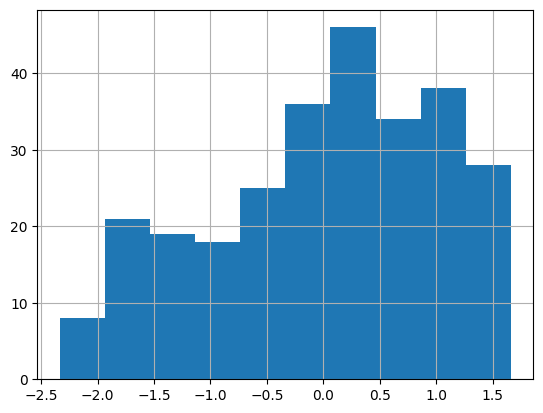

semicon


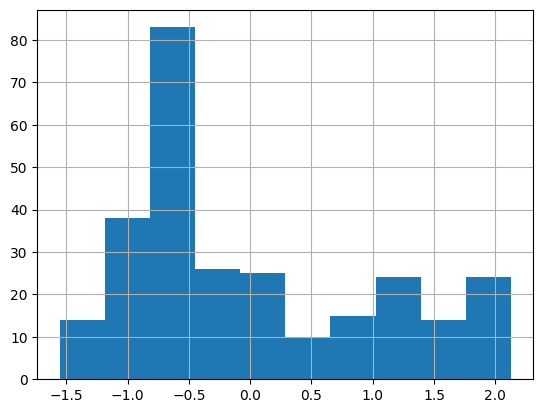

^GSPC


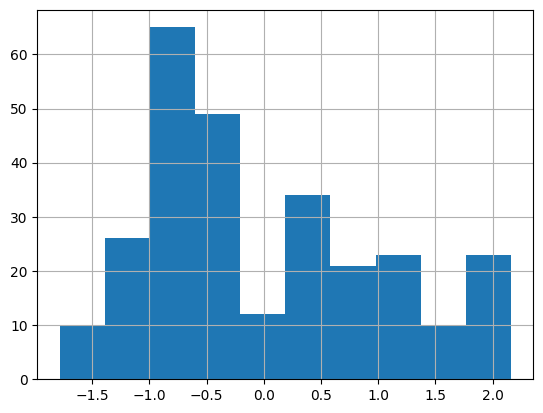

^VIX


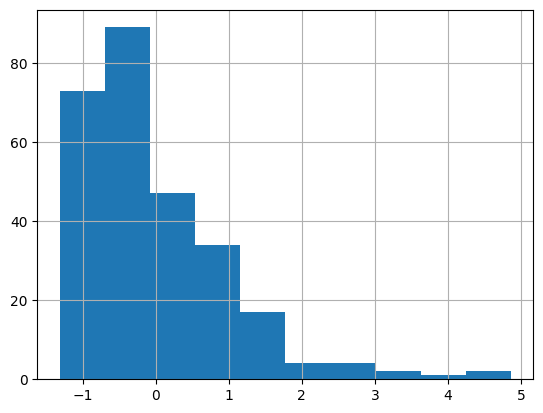

GC=F


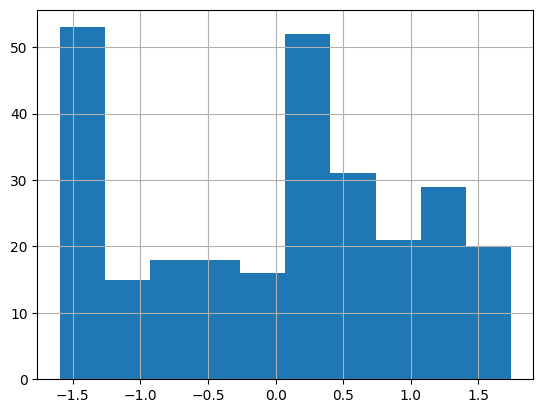

^TNX


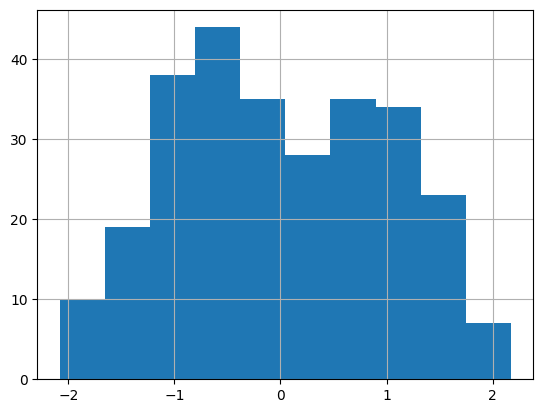

DX-Y.NYB


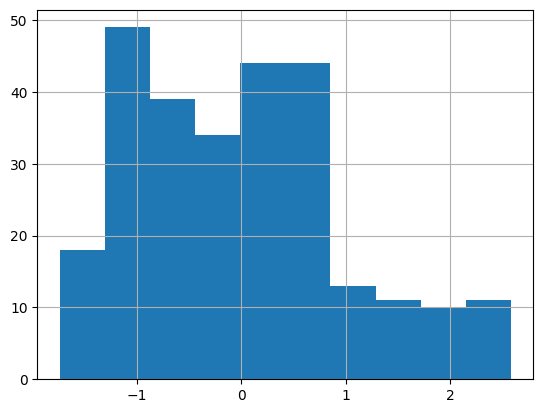

CPIAUCSL


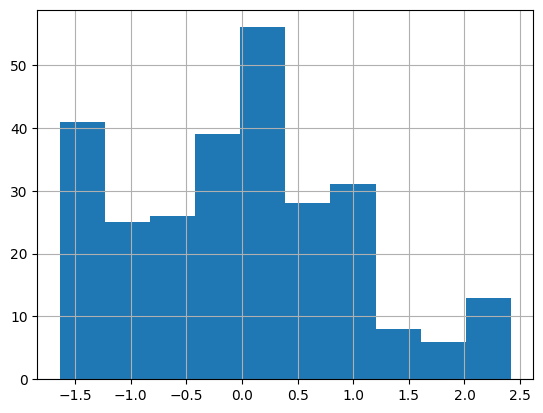

In [700]:
for column in read.columns:
    #plt.subplot(221)
    print(column)
    read[column].hist()
    plt.show()

# Unit root test
### - DFGLS
### - ADF
### - KPSS
### - PP

In [701]:
for column in read.columns:
    print(column)
    print(DFGLS(read[column], max_lags=10).summary())
    print("\n")
          

hardware
      Dickey-Fuller GLS Results      
Test Statistic                  0.356
P-value                         0.802
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -2.64 (1%), -2.02 (5%), -1.70 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


semicon
      Dickey-Fuller GLS Results      
Test Statistic                  0.216
P-value                         0.763
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -2.64 (1%), -2.02 (5%), -1.70 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


^GSPC
      Dickey-Fuller GLS Results      
Test Statistic                  0.675
P-value                         0.874
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -2.64 (1%),

In [702]:
for column in read.columns:
    print(column)
    print(ADF(read[column], max_lags=12).summary())
    print("\n")

hardware
   Augmented Dickey-Fuller Results   
Test Statistic                 -0.489
P-value                         0.894
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


semicon
   Augmented Dickey-Fuller Results   
Test Statistic                  0.131
P-value                         0.968
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


^GSPC
   Augmented Dickey-Fuller Results   
Test Statistic                  0.323
P-value                         0.978
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%),

In [703]:
for column in read.columns:
    print(column)
    print(KPSS(read[column], lags=12).summary())
    print("\n")

hardware
    KPSS Stationarity Test Results   
Test Statistic                  2.038
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


semicon
    KPSS Stationarity Test Results   
Test Statistic                  1.872
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


^GSPC
    KPSS Stationarity Test Results   
Test Statistic                  1.890
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (

In [704]:
for column in read.columns:
    print(column)
    print(PhillipsPerron(read[column], lags=12).summary())
    print("\n")

hardware
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.511
P-value                         0.890
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


semicon
     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.218
P-value                         0.973
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


^GSPC
     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.159
P-value                         0.970
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%),

# VECM VAR lag order selection

In [705]:
order = vecm.select_order(read,maxlags=12) 
print(order.summary())


 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -37.90     -36.91*   3.481e-17     -37.50*
1      -37.95*      -36.09  3.313e-17*      -37.20
2       -37.85      -35.11   3.669e-17      -36.75
3       -37.60      -33.99   4.721e-17      -36.15
4       -37.39      -32.90   5.888e-17      -35.59
5       -37.17      -31.80   7.474e-17      -35.01
6       -37.13      -30.88   7.954e-17      -34.62
7       -36.97      -29.84   9.634e-17      -34.10
8       -36.75      -28.75   1.244e-16      -33.53
9       -36.69      -27.82   1.378e-16      -33.12
10      -36.68      -26.93   1.483e-16      -32.76
11      -36.57      -25.94   1.783e-16      -32.29
12      -36.56      -25.06   1.949e-16      -31.94
--------------------------------------------------


# VECM cointegration test

In [706]:
rank = vecm.select_coint_rank(read, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(rank.summary())
    

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          63.38          62.17
  1   2          50.31          55.82
-------------------------------------


In [707]:
rank = vecm.select_coint_rank(read, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(rank.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   8          213.3          187.2
  1   8          149.9          150.1
-------------------------------------


In [748]:
model = vecm.VECM(read.head(263), k_ar_diff=1, coint_rank=1 ,deterministic='coli', seasons=0) 
res = model.fit()
print(res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation hardware
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0709      0.047     -1.499      0.134      -0.164       0.022
L1.hardware     0.0541      0.109      0.497      0.619      -0.159       0.267
L1.semicon     -0.0704      0.109     -0.644      0.519      -0.284       0.144
L1.^GSPC        0.1343      0.161      0.832      0.406      -0.182       0.451
L1.^VIX        -0.0115      0.015     -0.746      0.456      -0.042       0.019
L1.GC=F        -0.0921      0.068     -1.360      0.174      -0.225       0.041
L1.^TNX        -0.0468      0.036     -1.289      0.198      -0.118       0.024
L1.DX-Y.NYB    -0.0390      0.041     -0.959      0.338      -0.119       0.041
L1.CPIAUCSL     0.2242      0.312      0.718      0.473      -0.388       0.836
Det. terms outside the coint. re

In [749]:
allpred = res.predict(steps=10)
pred = []
for step in allpred:
    pred.append(step[1])

pred

[1.8537125243464896,
 1.856640609198173,
 1.8612567296658435,
 1.8665066538642796,
 1.8721254305065012,
 1.8781206821362637,
 1.8844291556695394,
 1.8909998698974313,
 1.8977871789571732,
 1.9047531260656039]

In [750]:
statsmodels.tools.eval_measures.meanabs(pred, read["hardware"].tail(10))

0.5533200668367413

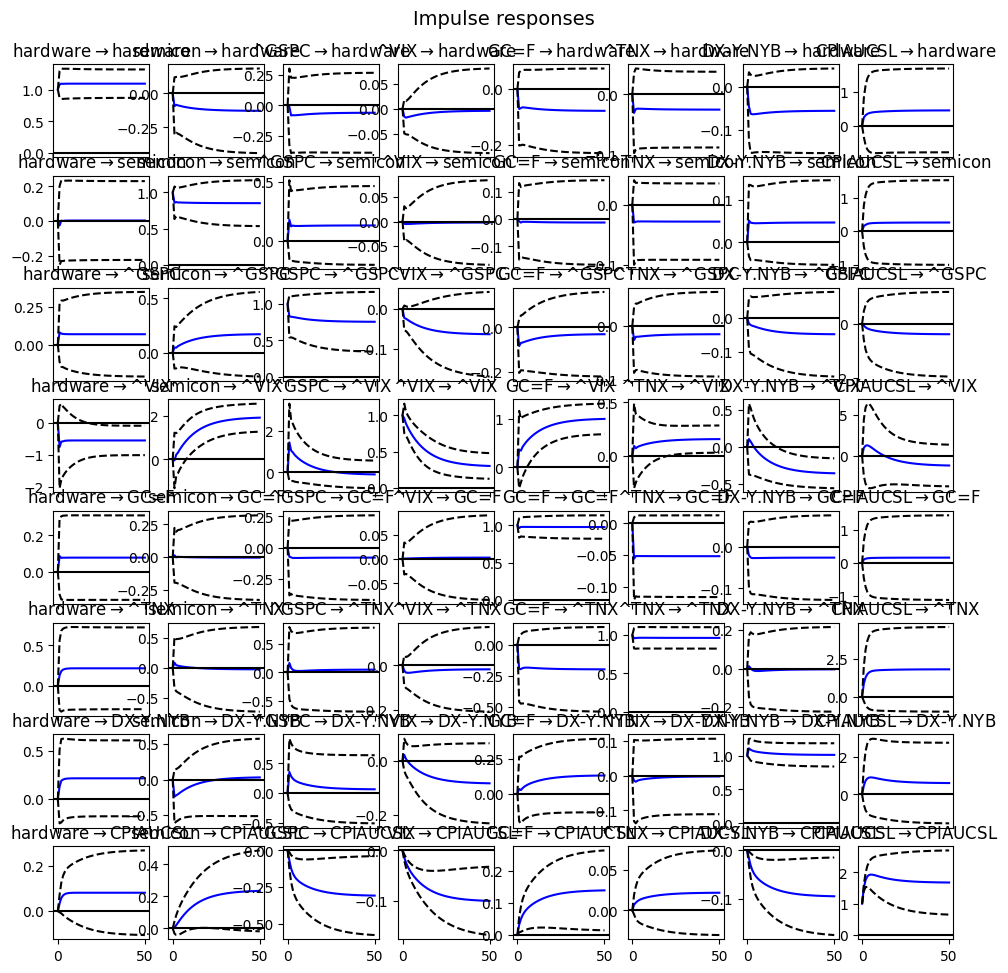

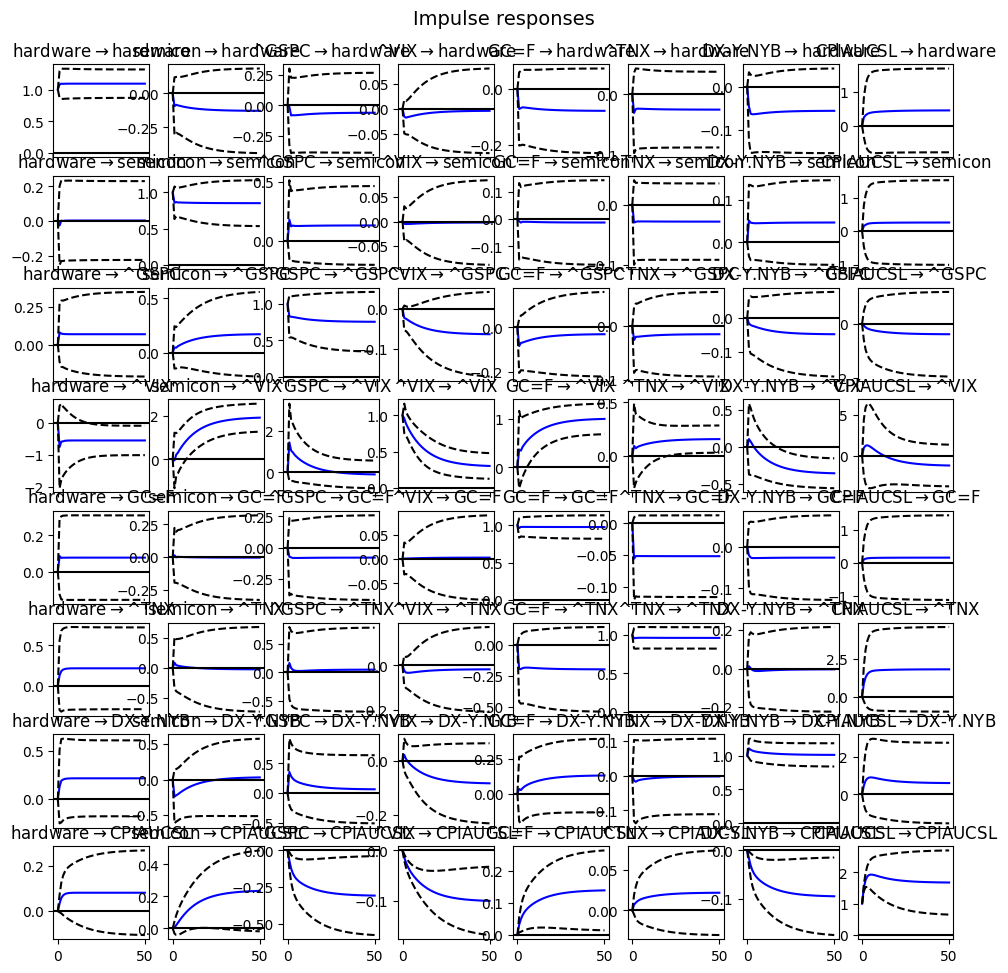

In [714]:
res.irf(50).plot()

In [710]:
causality_vs_each(read, res)

Granger causality F-test. H_0: semicon does not Granger-cause hardware. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.7591          3.000   0.468 (2, 1960)
-----------------------------------------------


Granger causality F-test. H_0: ^GSPC does not Granger-cause hardware. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.6255          3.000   0.535 (2, 1960)
-----------------------------------------------


Granger causality F-test. H_0: ^VIX does not Granger-cause hardware. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.3053          3.000   0.737 (2, 1960)
-----------------------------------------------


Granger causality F-test. H_0: GC=F 

In [711]:
res.alpha*res.beta

array([[ 5.19229789e-04],
       [-1.15759216e-02],
       [-1.72481774e-02],
       [-1.00318367e-01],
       [-4.93109350e-03],
       [-4.39081659e-05],
       [-3.03397680e-03],
       [-1.52093481e-03]])

In [712]:
res.gamma

array([[ 8.21092697e-02, -9.36914194e-02, -3.64258005e-02,
        -1.89149788e-02, -7.80368645e-02, -1.92242803e-02,
        -5.41118170e-02, -7.10133065e-03],
       [-2.65521263e-02, -1.41568429e-01,  1.74032643e-01,
        -7.74652674e-03, -1.50781878e-02, -1.74607419e-02,
         4.29431704e-02, -1.04928031e-01],
       [ 8.02509448e-02,  2.68041462e-02, -1.74360865e-01,
        -1.62145266e-02, -9.45754088e-02, -2.21699484e-02,
        -1.38614515e-02, -1.66499649e-01],
       [-7.05813277e-01, -1.21762500e-01,  1.16978221e+00,
        -8.04363166e-03,  4.00710213e-01, -1.48632144e-02,
         1.84087465e-01,  2.74656200e+00],
       [ 7.58211483e-02,  9.61367388e-03, -2.69591843e-02,
         2.12990470e-03, -4.74248512e-02, -4.10158370e-02,
        -2.74825700e-02, -1.46992861e-01],
       [ 1.56392579e-01,  1.16046569e-01,  5.90804692e-02,
        -3.46542419e-02, -1.77754045e-01, -5.40638655e-02,
         1.12657286e-02,  1.05689011e+00],
       [ 1.38223651e-01, -2.310792

In [741]:
res.var_rep

array([[[ 1.04324844e+00, -1.10189234e-01,  1.63162227e-01,
          5.68814280e-04, -9.32358229e-02, -3.72807173e-02,
         -3.52892364e-02,  2.03682241e-01],
        [-6.42108844e-02,  8.52179712e-01,  3.22187033e-01,
          9.33097677e-03, -2.64508477e-02, -3.59398171e-02,
          6.15320130e-02, -1.35928088e-02],
        [ 7.20614622e-02,  4.90287167e-02,  9.28044395e-01,
         -1.41626669e-02, -1.06572581e-01, -4.99461006e-02,
         -1.05325960e-02, -1.02482532e-01],
        [-6.77089967e-01,  2.58519061e-01,  7.65630834e-01,
          8.80637594e-01,  5.15488983e-01, -3.43048201e-02,
          7.81243021e-02,  2.61009795e+00],
        [ 9.40467230e-02, -3.30478713e-02, -1.98138873e-02,
          7.34403834e-03,  9.32952770e-01, -4.52200582e-02,
         -2.01627952e-02, -2.35810325e-01],
        [ 2.14369466e-01,  1.74937356e-01, -1.73149335e-01,
         -6.05015311e-02, -1.36746425e-01,  9.42627968e-01,
         -2.57403784e-02,  7.67731120e-01],
        [ 1.1752